## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime

# Add src directory to path to import our modules
sys.path.append('../src')
from data_processing import load_data, preprocess_data, generate_rfms_features, create_risk_proxy, get_feature_correlations

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:

# Load and preprocess the data
DATA_PATH = '../data/data.csv'  # Adjust path as needed
raw_df = load_data(DATA_PATH)
df = preprocess_data(raw_df)

2025-07-03 14:50:13,509 - INFO - Loading data from ../data/data.csv...
2025-07-03 14:50:24,526 - INFO - Data loaded successfully.
2025-07-03 14:50:24,527 - INFO - Starting data preprocessing...
2025-07-03 14:50:25,688 - INFO - Data preprocessing complete.


### Cell 5 - Markdown
#### 2. Overview of the Data
##### Understand the structure of the dataset, including the number of rows, columns, data types, and missing values.

In [5]:

print(f"Dataset shape: {df.shape}")
print("\nData Types:")
print(df.info())

print("\nMissing Values (%):")
print(df.isnull().sum() / len(df) * 100)

Dataset shape: (95662, 16)

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95662 entries, 0 to 95661
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   TransactionId         95662 non-null  object             
 1   BatchId               95662 non-null  object             
 2   AccountId             95662 non-null  object             
 3   SubscriptionId        95662 non-null  object             
 4   CustomerId            95662 non-null  object             
 5   CurrencyCode          95662 non-null  object             
 6   CountryCode           95662 non-null  int64              
 7   ProviderId            95662 non-null  object             
 8   ProductId             95662 non-null  object             
 9   ProductCategory       95662 non-null  object             
 10  ChannelId             95662 non-null  object             
 11  Amount                95662

In [ ]:
## 3. Feature Engineering: RFMS + Proxy Variable
# 
# Now we'll use our processing functions to engineer the behavioral features and create the risk proxy. This is the core of our analysis.

In [7]:
# Define a snapshot date for recency calculation (e.g., one day after the last transaction)
snapshot_date = df['TransactionStartTime'].max() + pd.Timedelta(days=1)

# Generate RFMS features
rfms_features = generate_rfms_features(df, snapshot_date)

# Create the risk proxy
# We need the fraud result from the original dataframe for this
fraud_data = df[['CustomerId', 'FraudResult']]
final_features_df = create_risk_proxy(rfms_features, fraud_data)

print("Generated Features and Proxy Variable DataFrame:")
final_features_df.head()

2025-07-03 14:57:05,842 - INFO - Generating RFMS features...
2025-07-03 14:57:08,017 - INFO - RFMS feature generation complete.
2025-07-03 14:57:08,047 - INFO - Creating risk proxy variable...
c:\Users\Senayit\Desktop\10x\Credit_Risk_Probability_w5\notebook\../src\data_processing.py:127: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalFraudTransactions'].fillna(0, inplace=True)
2025-07-03 14:57:08,828 - INFO - Risk proxy created. High-risk proportion: 22.26%


Generated Features and Proxy Variable DataFrame:


,CustomerId,Recency,Frequency,Monetary,Std_Dev_Amount,R_Score,F_Score,M_Score,RFM_Score,TotalFraudTransactions,high_risk
0,CustomerId_1,84,1,10000,0.000000,1,1,2,4,0,1
1,CustomerId_10,84,1,10000,0.000000,1,1,2,4,0,1
2,CustomerId_1001,90,5,30400,4100.243895,1,2,3,6,0,0
3,CustomerId_1002,26,11,4775,518.805446,3,4,2,9,0,0
4,CustomerId_1003,12,6,32000,3945.461528,4,3,3,10,0,0


##### 4. Distribution of Engineered Features
##### Let's visualize the distributions of our new `Recency`, `Frequency`, `Monetary`, and `Std_Dev_Amount` features.

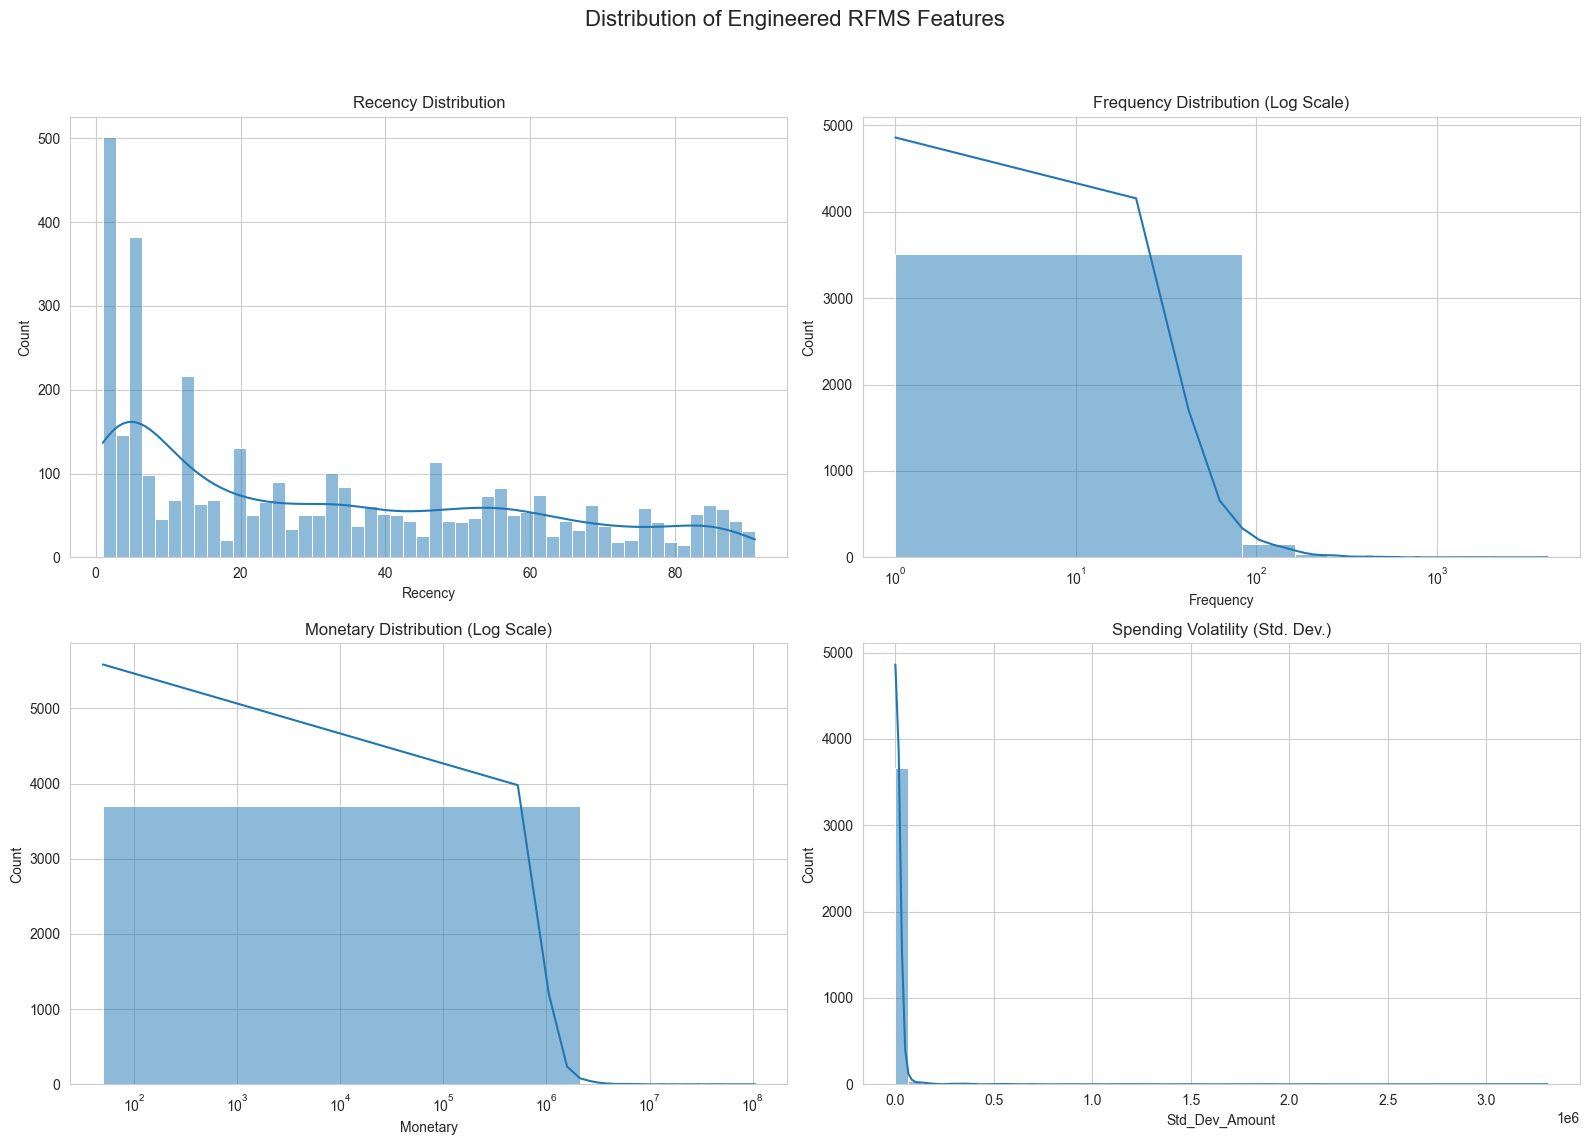

In [8]:

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Engineered RFMS Features', fontsize=16)

sns.histplot(final_features_df['Recency'], ax=axes[0, 0], kde=True, bins=50).set_title('Recency Distribution')
sns.histplot(final_features_df['Frequency'], ax=axes[0, 1], kde=True, bins=50).set_title('Frequency Distribution (Log Scale)')
axes[0, 1].set_xscale('log')  # Frequency is often highly skewed

sns.histplot(final_features_df['Monetary'], ax=axes[1, 0], kde=True, bins=50).set_title('Monetary Distribution (Log Scale)')
axes[1, 0].set_xscale('log')  # Monetary is often highly skewed

sns.histplot(final_features_df['Std_Dev_Amount'], ax=axes[1, 1], kde=True, bins=50).set_title('Spending Volatility (Std. Dev.)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Box Plots for Outlier Detection

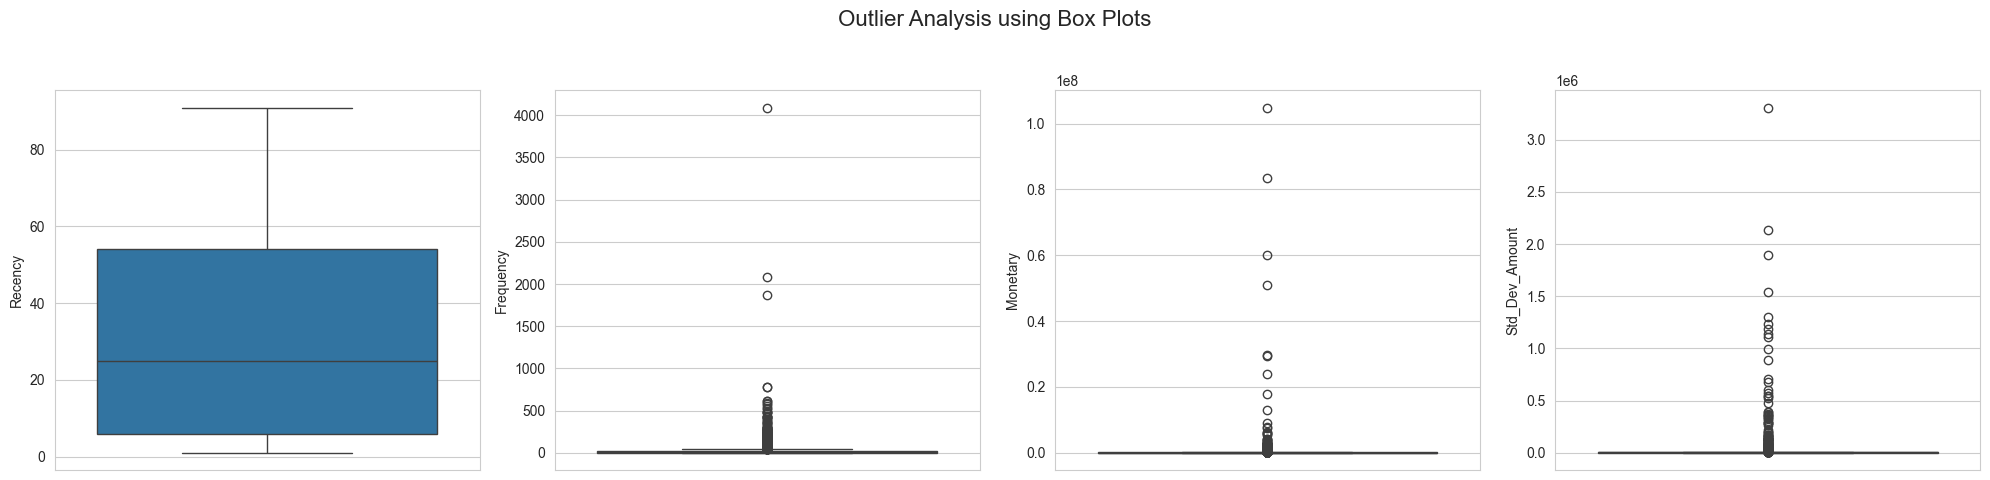

In [9]:

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Outlier Analysis using Box Plots', fontsize=16)
sns.boxplot(y=final_features_df['Recency'], ax=axes[0])
sns.boxplot(y=final_features_df['Frequency'], ax=axes[1])
sns.boxplot(y=final_features_df['Monetary'], ax=axes[2])
sns.boxplot(y=final_features_df['Std_Dev_Amount'], ax=axes[3])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


##### 5. Feature Correlation with Risk Proxy 
##### This is a critical step to validate our feature engineering. We need to see if the features we created have a strong relationship with the `high_risk` proxy variable. This will inform our feature selection for the model.

2025-07-03 15:01:20,321 - INFO - Calculating feature correlations with target 'high_risk'...
2025-07-03 15:01:20,428 - INFO - Correlation calculation complete.


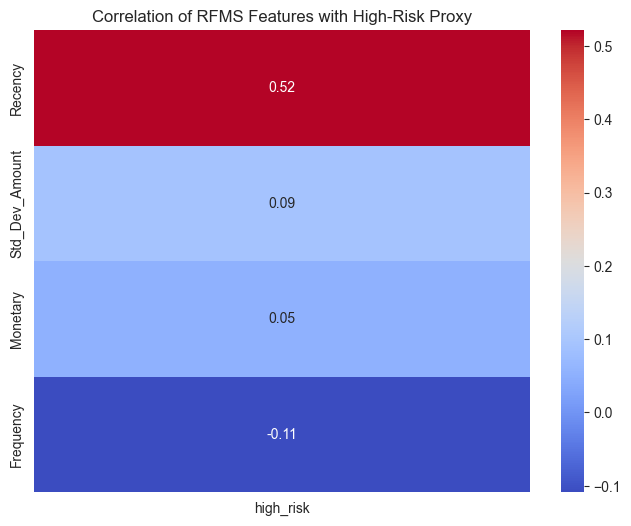

Correlation values:
                high_risk
Recency          0.521609
Std_Dev_Amount   0.091881
Monetary         0.051386
Frequency       -0.108733


In [10]:
# Cell 14 - Code
feature_corr = get_feature_correlations(final_features_df[['Recency', 'Frequency', 'Monetary', 'Std_Dev_Amount', 'high_risk']], 'high_risk')

plt.figure(figsize=(8, 6))
sns.heatmap(feature_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of RFMS Features with High-Risk Proxy')
plt.show()

print("Correlation values:")
print(feature_corr)